In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Financial stocks

### First BanCorp (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/FBP_data.csv")
print(df.head())

         Date  previous_1d      EMA_12  willr_14    OBV_7  labels
0  2000-01-21     100.0000  100.813609     -64.0 -21460.0     2.0
1  2000-01-24      97.1875  100.255746    -100.0 -28200.0     2.0
2  2000-01-25      96.2500   99.639478    -100.0 -32420.0     2.0
3  2000-01-26      93.1250   98.637250    -100.0 -42580.0     2.0
4  2000-01-27      94.0625   97.933443     -90.0 -36840.0     2.0


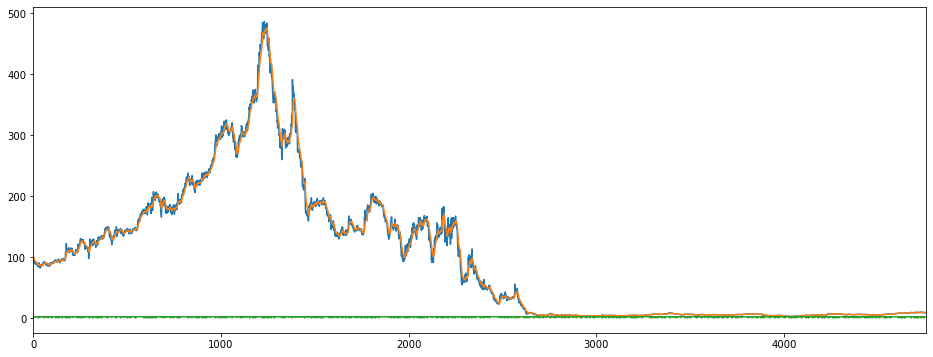

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,100.0000,100.813609,-64.0,-21460.0,2.0
2000-01-24,97.1875,100.255746,-100.0,-28200.0,2.0
2000-01-25,96.2500,99.639478,-100.0,-32420.0,2.0
2000-01-26,93.1250,98.637250,-100.0,-42580.0,2.0
2000-01-27,94.0625,97.933443,-90.0,-36840.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

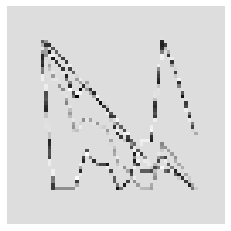

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3140655105973025, 1: 7.3140655105973025, 2: 0.36676328502415456}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.3643 - accuracy: 0.7109 - mse: 5.5269 - weighted_accuracy: 0.4395 - weighted_mse: 5.2575WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 25ms/step - loss: 0.2425 - accuracy: 0.3001 - mse: 1.6672 - weighted_accuracy: 0.3223 - weighted_mse: 1.6385 - val_loss: 0.2284 - val_accuracy: 0.0464 - val_mse: 0.8322 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.8322
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2064 - accuracy: 0.2745 - mse: 1.1962 - weighted_accuracy: 0.3404 - weighted_mse: 1.1836 - val_loss: 0.2034 - val_accuracy: 0.0611 -

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.3406 - mse: 1.1673 - weighted_accuracy: 0.3775 - weighted_mse: 1.1713 - val_loss: 0.1986 - val_accuracy: 0.0917 - val_mse: 0.9262 - val_weighted_accuracy: 0.0917 - val_weighted_mse: 0.9262
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1930 - accuracy: 0.3101 - mse: 1.1890 - weighted_accuracy: 0.4248 - weighted_mse: 1.1862 - val_loss: 0.1938 - val_accuracy: 0.1570 - val_mse: 0.9967 - val_weighted_accuracy: 0.1570 - val_weighted_mse: 0.9967
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1980 - accuracy: 0.3048 - mse: 1.1775 - weighted_accuracy: 0.3644 - weighted_mse: 1.1780 - val_loss: 0.1944 - val_accuracy: 0.1454 - val_mse: 0.9844 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 0.9844
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1954 - accuracy: 0.3006 - mse: 1.2094 - weighted_accuracy: 0.3884 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.2187 - mse: 1.2603 - weighted_accuracy: 0.4938 - weighted_mse: 1.2216 - val_loss: 0.1907 - val_accuracy: 0.2150 - val_mse: 1.0894 - val_weighted_accuracy: 0.2150 - val_weighted_mse: 1.0894
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1851 - accuracy: 0.2237 - mse: 1.2723 - weighted_accuracy: 0.4426 - weighted_mse: 1.2194 - val_loss: 0.1936 - val_accuracy: 0.1222 - val_mse: 1.1209 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 1.1209
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1789 - accuracy: 0.2192 - mse: 1.2611 - weighted_accuracy: 0.4995 - weighted_mse: 1.2364 - val_loss: 0.1921 - val_accuracy: 0.1465 - val_mse: 1.0473 - val_weighted_accuracy: 0.1465 - val_weighted_mse: 1.0473
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1804 - accuracy: 0.2252 - mse: 1.2907 - weighted_accuracy: 0.4724 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1619 - accuracy: 0.2389 - mse: 1.3710 - weighted_accuracy: 0.5671 - weighted_mse: 1.3209 - val_loss: 0.1901 - val_accuracy: 0.1970 - val_mse: 1.1790 - val_weighted_accuracy: 0.1970 - val_weighted_mse: 1.1790
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1578 - accuracy: 0.2210 - mse: 1.3957 - weighted_accuracy: 0.5990 - weighted_mse: 1.3640 - val_loss: 0.1912 - val_accuracy: 0.2129 - val_mse: 1.2834 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.2834
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1612 - accuracy: 0.2252 - mse: 1.3892 - weighted_accuracy: 0.5694 - weighted_mse: 1.3223 - val_loss: 0.1939 - val_accuracy: 0.1928 - val_mse: 1.3096 - val_weighted_accuracy: 0.1928 - val_weighted_mse: 1.3096
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1582 - accuracy: 0.2376 - mse: 1.3812 - weighted_accuracy: 0.6142 - wei

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1393 - accuracy: 0.3577 - mse: 1.5913 - weighted_accuracy: 0.6748 - weighted_mse: 1.6079 - val_loss: 0.1810 - val_accuracy: 0.4004 - val_mse: 1.4217 - val_weighted_accuracy: 0.4004 - val_weighted_mse: 1.4217
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.3559 - mse: 1.6511 - weighted_accuracy: 0.6997 - weighted_mse: 1.7378 - val_loss: 0.1802 - val_accuracy: 0.4078 - val_mse: 1.4632 - val_weighted_accuracy: 0.4078 - val_weighted_mse: 1.4632
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1363 - accuracy: 0.3738 - mse: 1.6250 - weighted_accuracy: 0.6752 - weighted_mse: 1.6738 - val_loss: 0.1782 - val_accuracy: 0.4362 - val_mse: 1.4739 - val_weighted_accuracy: 0.4362 - val_weighted_mse: 1.4739
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.3628 - mse: 1.6267 - weighted_accuracy: 0.6821 

Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1182 - accuracy: 0.5192 - mse: 1.9659 - weighted_accuracy: 0.7395 - weighted_mse: 2.2082 - val_loss: 0.1748 - val_accuracy: 0.4721 - val_mse: 1.6230 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.6230
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1166 - accuracy: 0.4987 - mse: 1.9481 - weighted_accuracy: 0.7283 - weighted_mse: 2.2782 - val_loss: 0.1570 - val_accuracy: 0.6038 - val_mse: 1.5913 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 1.5913
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1226 - accuracy: 0.5171 - mse: 1.9658 - weighted_accuracy: 0.7259 - weighted_mse: 2.1893 - val_loss: 0.1465 - val_accuracy: 0.6702 - val_mse: 1.6669 - val_weighted_accuracy: 0.6702 - val_weighted_mse: 1.6669
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1161 - accuracy: 0.5453 - mse: 1.9470 - weighted_accuracy: 0.7490 -

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1064 - accuracy: 0.6291 - mse: 2.3032 - weighted_accuracy: 0.7743 - weighted_mse: 2.7403 - val_loss: 0.1404 - val_accuracy: 0.6955 - val_mse: 1.8182 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 1.8182
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1030 - accuracy: 0.6291 - mse: 2.4266 - weighted_accuracy: 0.7725 - weighted_mse: 3.0657 - val_loss: 0.1436 - val_accuracy: 0.6786 - val_mse: 1.9094 - val_weighted_accuracy: 0.6786 - val_weighted_mse: 1.9094
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1041 - accuracy: 0.6272 - mse: 2.3826 - weighted_accuracy: 0.7809 - weighted_mse: 2.9276 - val_loss: 0.1401 - val_accuracy: 0.6902 - val_mse: 1.8648 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 1.8648
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1023 - accuracy: 0.6035 - mse: 2.3368 - weighted_accuracy: 0.7631 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11975139379501343
Test accuracy: 0.7723919749259949


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.4109327  -1.3497796   0.10297372]
 [-1.5000745  -1.3711056   0.11543896]
 [-0.8243416  -2.045944   -0.10530666]
 ...
 [-0.25272828 -2.3122168  -0.5478402 ]
 [-1.5875703  -0.40403637 -0.42317763]
 [ 0.5751946  -3.1969285  -1.2058784 ]]


Counter({2: 796, 0: 79, 1: 74})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 37
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 36
actual holds but predicted buy: 71
actual holds but predicted sell: 69
actual predicted holds: 723
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 83.77752027809966%
actual buys: 43
actual sells: 43
actual holds: 863


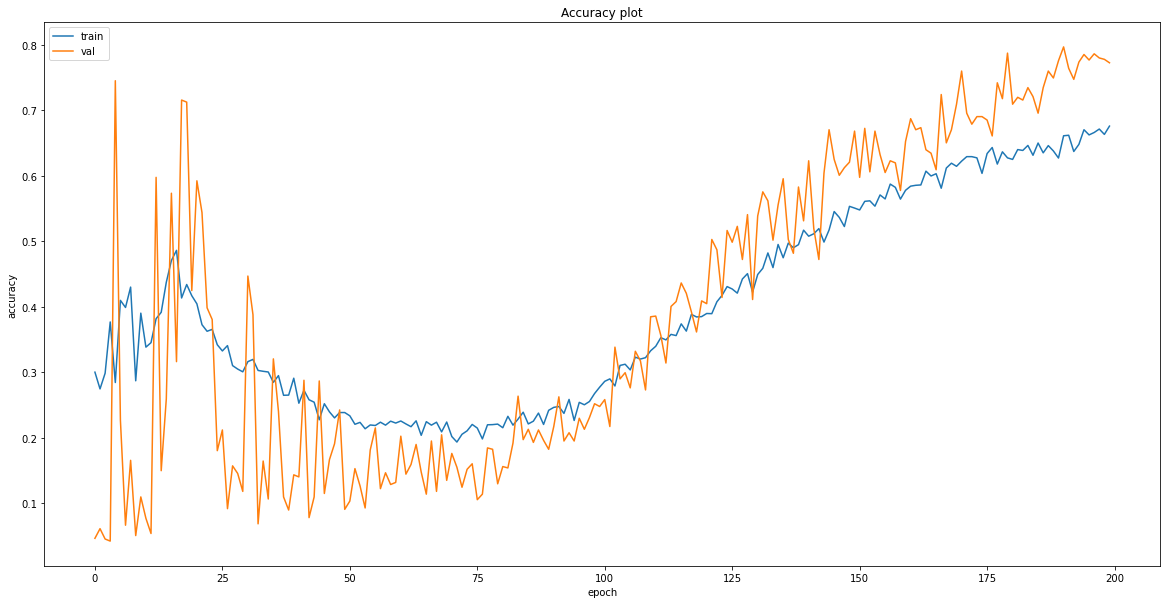

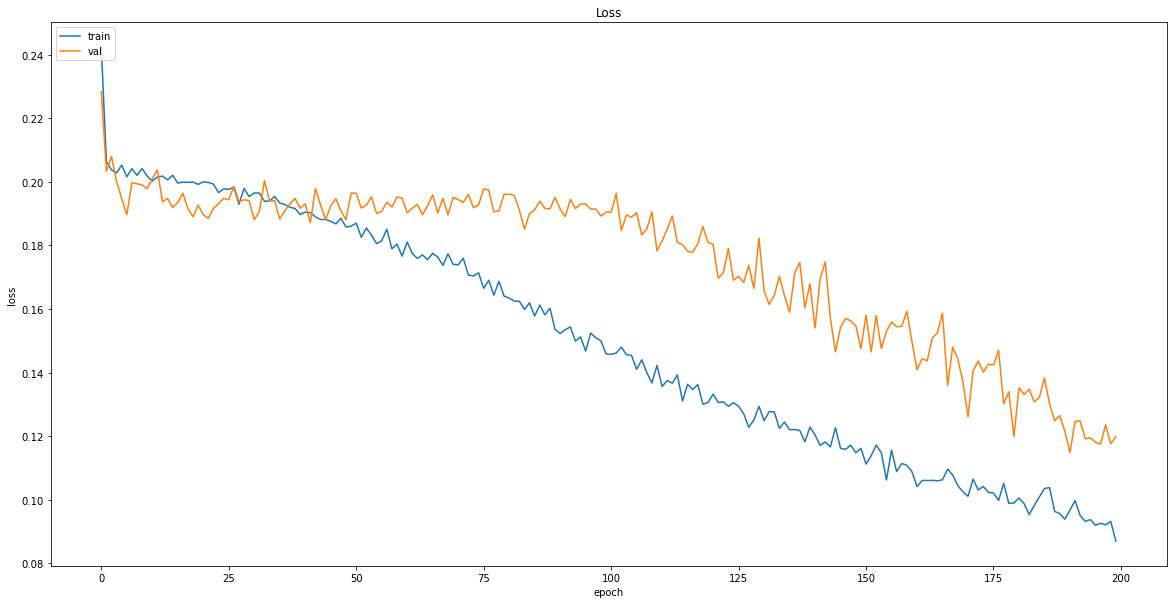

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('FBP_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/FBP_image_cnn_buy_hold_sell.model\assets


### American Financial Group, Inc (Mid Cap)

In [28]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/AFG_data.csv")
print(df.head())

         Date  previous_1d     EMA_12    willr_14      OBV_7  labels
0  2000-01-21    15.000000  16.189452 -100.000000  -550650.0     2.0
1  2000-01-24    15.166667  16.032100  -93.103439  -477300.0     2.0
2  2000-01-25    14.875000  15.854085  -92.187507  -762150.0     2.0
3  2000-01-26    14.708333  15.677815  -95.454544 -1036650.0     2.0
4  2000-01-27    14.666667  15.522254  -88.888864 -1157250.0     2.0


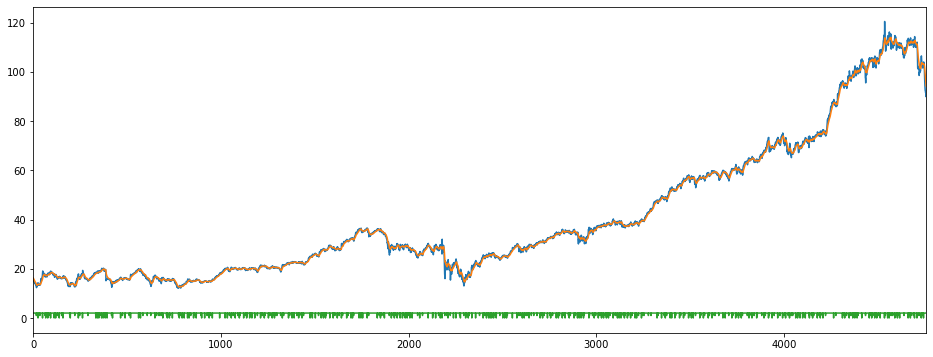

In [29]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,15.000000,16.189452,-100.000000,-550650.0,2.0
2000-01-24,15.166667,16.032100,-93.103439,-477300.0,2.0
2000-01-25,14.875000,15.854085,-92.187507,-762150.0,2.0
2000-01-26,14.708333,15.677815,-95.454544,-1036650.0,2.0
2000-01-27,14.666667,15.522254,-88.888864,-1157250.0,2.0


In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

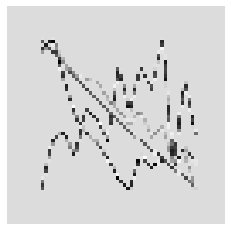

In [36]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [37]:
X = X/255

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.272030651340996, 2: 0.36697602474864655}
Epoch 1/200
30/30 [==============================] - 1s 47ms/step - loss: 0.2434 - accuracy: 0.3978 - mse: 1.5712 - weighted_accuracy: 0.3079 - weighted_mse: 1.6464 - val_loss: 0.2080 - val_accuracy: 0.0421 - val_mse: 0.8953 - val_weighted_accuracy: 0.0421 - val_weighted_mse: 0.8953
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2053 - accuracy: 0.4539 - mse: 1.1624 - weighted_accuracy: 0.3321 - weighted_mse: 1.1833 - val_loss: 0.1926 - val_accuracy: 0.9083 - val_mse: 0.8112 - val_weighted_accuracy: 0.9083 - val_weighted_mse: 0.8112
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2063 - accuracy: 0.5400 - mse: 1.0844 - weighted_accuracy: 0.3000 - weighted_mse: 1.1318 - val_loss: 0.1878 - val_accuracy: 0.8988 - val_mse: 0.9038 - val_weighted_accuracy: 0.8988 - val_weighted_mse: 0.9038
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2031 -

30/30 [==============================] - 0s 9ms/step - loss: 0.2011 - accuracy: 0.2742 - mse: 1.1537 - weighted_accuracy: 0.3371 - weighted_mse: 1.1339 - val_loss: 0.2006 - val_accuracy: 0.0611 - val_mse: 0.9241 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 0.9241
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2002 - accuracy: 0.2848 - mse: 1.1568 - weighted_accuracy: 0.3373 - weighted_mse: 1.1508 - val_loss: 0.2023 - val_accuracy: 0.0653 - val_mse: 0.9391 - val_weighted_accuracy: 0.0653 - val_weighted_mse: 0.9391
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2002 - accuracy: 0.2782 - mse: 1.1501 - weighted_accuracy: 0.3477 - weighted_mse: 1.1425 - val_loss: 0.1973 - val_accuracy: 0.0495 - val_mse: 0.9259 - val_weighted_accuracy: 0.0495 - val_weighted_mse: 0.9259
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1990 - accuracy: 0.2671 - mse: 1.1535 - weighted_accuracy: 0.3454 - weighted_mse: 1.1

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1905 - accuracy: 0.1836 - mse: 1.1571 - weighted_accuracy: 0.4530 - weighted_mse: 1.1413 - val_loss: 0.1941 - val_accuracy: 0.0643 - val_mse: 1.2317 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 1.2317
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1896 - accuracy: 0.1699 - mse: 1.1942 - weighted_accuracy: 0.4334 - weighted_mse: 1.1740 - val_loss: 0.1949 - val_accuracy: 0.0664 - val_mse: 1.0790 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 1.0790
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1884 - accuracy: 0.1739 - mse: 1.1683 - weighted_accuracy: 0.4585 - weighted_mse: 1.1489 - val_loss: 0.1970 - val_accuracy: 0.0674 - val_mse: 1.0905 - val_weighted_accuracy: 0.0674 - val_weighted_mse: 1.0905
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1874 - accuracy: 0.1657 - mse: 1.1818 - weighted_accuracy: 0.4483 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1621 - accuracy: 0.1620 - mse: 1.3760 - weighted_accuracy: 0.5561 - weighted_mse: 1.3385 - val_loss: 0.1960 - val_accuracy: 0.0832 - val_mse: 1.2704 - val_weighted_accuracy: 0.0832 - val_weighted_mse: 1.2704
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1591 - accuracy: 0.1538 - mse: 1.3820 - weighted_accuracy: 0.5585 - weighted_mse: 1.3518 - val_loss: 0.1964 - val_accuracy: 0.0896 - val_mse: 1.3021 - val_weighted_accuracy: 0.0896 - val_weighted_mse: 1.3021
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1604 - accuracy: 0.1689 - mse: 1.3784 - weighted_accuracy: 0.5531 - weighted_mse: 1.3420 - val_loss: 0.1980 - val_accuracy: 0.0969 - val_mse: 1.3095 - val_weighted_accuracy: 0.0969 - val_weighted_mse: 1.3095
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1598 - accuracy: 0.1646 - mse: 1.3791 - weighted_accuracy: 0.5570 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1450 - accuracy: 0.3008 - mse: 1.5858 - weighted_accuracy: 0.5906 - weighted_mse: 1.6258 - val_loss: 0.1902 - val_accuracy: 0.2698 - val_mse: 1.4100 - val_weighted_accuracy: 0.2698 - val_weighted_mse: 1.4100
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1437 - accuracy: 0.3148 - mse: 1.5446 - weighted_accuracy: 0.5976 - weighted_mse: 1.6212 - val_loss: 0.1885 - val_accuracy: 0.3077 - val_mse: 1.4344 - val_weighted_accuracy: 0.3077 - val_weighted_mse: 1.4344
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1484 - accuracy: 0.3174 - mse: 1.5350 - weighted_accuracy: 0.5731 - weighted_mse: 1.5764 - val_loss: 0.1884 - val_accuracy: 0.3045 - val_mse: 1.4291 - val_weighted_accuracy: 0.3045 - val_weighted_mse: 1.4291
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1444 - accuracy: 0.3222 - mse: 1.5987 - weighted_accuracy: 0.5930 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1344 - accuracy: 0.4470 - mse: 1.8230 - weighted_accuracy: 0.6352 - weighted_mse: 2.0528 - val_loss: 0.1716 - val_accuracy: 0.5058 - val_mse: 1.6210 - val_weighted_accuracy: 0.5058 - val_weighted_mse: 1.6210
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1332 - accuracy: 0.4605 - mse: 1.7797 - weighted_accuracy: 0.6310 - weighted_mse: 2.0630 - val_loss: 0.1720 - val_accuracy: 0.4910 - val_mse: 1.5858 - val_weighted_accuracy: 0.4910 - val_weighted_mse: 1.5858
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1300 - accuracy: 0.4692 - mse: 1.8101 - weighted_accuracy: 0.6506 - weighted_mse: 2.1286 - val_loss: 0.1709 - val_accuracy: 0.4889 - val_mse: 1.5940 - val_weighted_accuracy: 0.4889 - val_weighted_mse: 1.5940
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.4773 - mse: 1.7999 - weighted_accuracy: 0.6590 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1268 - accuracy: 0.5245 - mse: 1.9474 - weighted_accuracy: 0.6563 - weighted_mse: 2.4783 - val_loss: 0.1572 - val_accuracy: 0.6175 - val_mse: 1.7232 - val_weighted_accuracy: 0.6175 - val_weighted_mse: 1.7232
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1172 - accuracy: 0.5530 - mse: 2.0714 - weighted_accuracy: 0.7104 - weighted_mse: 2.7666 - val_loss: 0.1568 - val_accuracy: 0.6291 - val_mse: 1.7187 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 1.7187
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1215 - accuracy: 0.5324 - mse: 2.0838 - weighted_accuracy: 0.6738 - weighted_mse: 2.7175 - val_loss: 0.1559 - val_accuracy: 0.6344 - val_mse: 1.7591 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 1.7591
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1234 - accuracy: 0.5374 - mse: 2.0305 - weighted_accuracy: 0.6720 - 

In [43]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1412287950515747
Test accuracy: 0.7123287916183472


In [44]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.72785515 -1.6274189  -0.4054685 ]
 [-1.4503961  -1.0256805  -0.23025006]
 [-1.3258941  -1.1763448  -0.21220604]
 ...
 [-2.071662   -0.38189518 -0.47244212]
 [-1.1103356  -1.1645911  -0.25398764]
 [-0.635768   -1.7300572  -0.4483915 ]]


Counter({2: 730, 1: 112, 0: 107})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 38
actual sells but predicted buy: 2
actual predicted sells: 11
actual sells but predicted hold: 31
actual holds but predicted buy: 106
actual holds but predicted sell: 95
actual predicted holds: 661
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 25.0%
Percentage holds correct: 76.68213457076565%
actual buys: 43
actual sells: 44
actual holds: 862


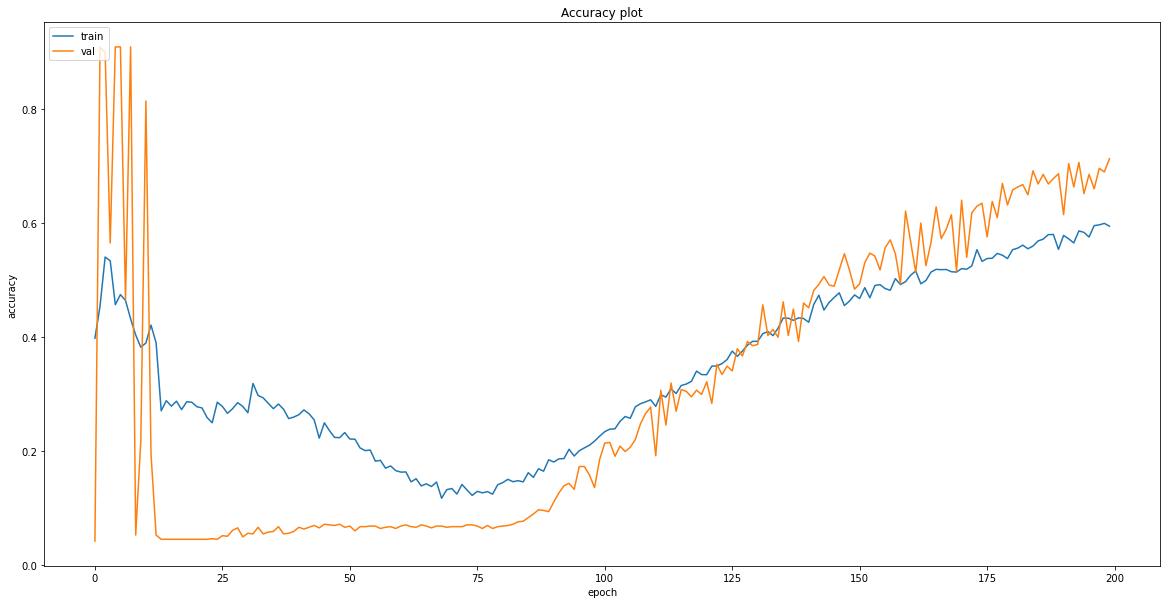

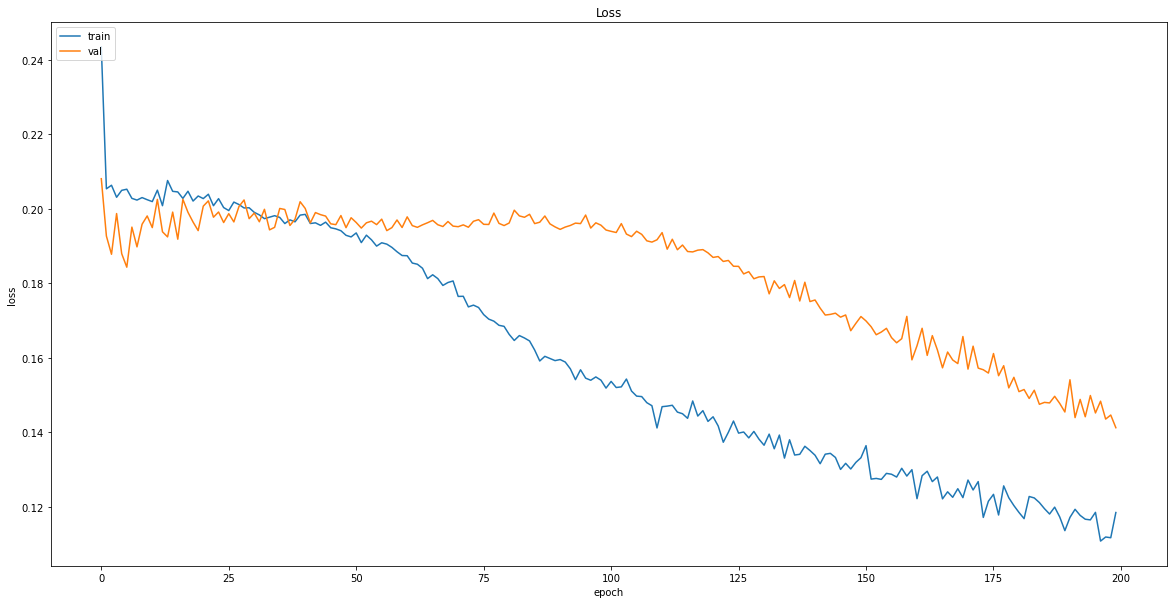

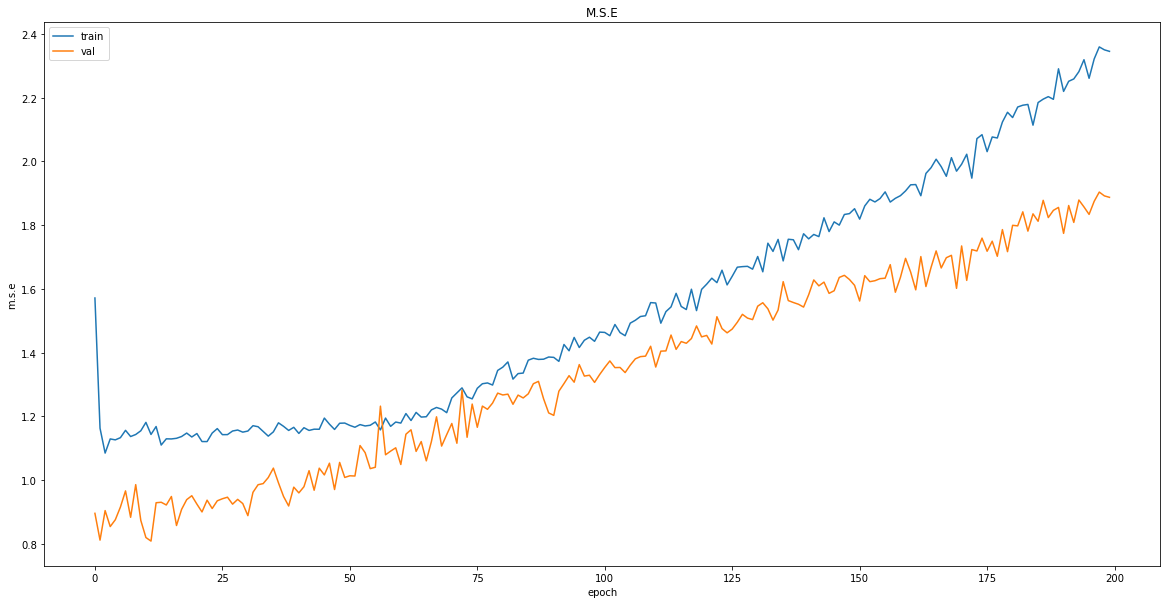

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Save model
model.save("models/{}".format('AFG_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/AFG_image_cnn_buy_hold_sell.model\assets


## JPMorgan Chase & Co. (Large Cap)

In [49]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/JPM_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


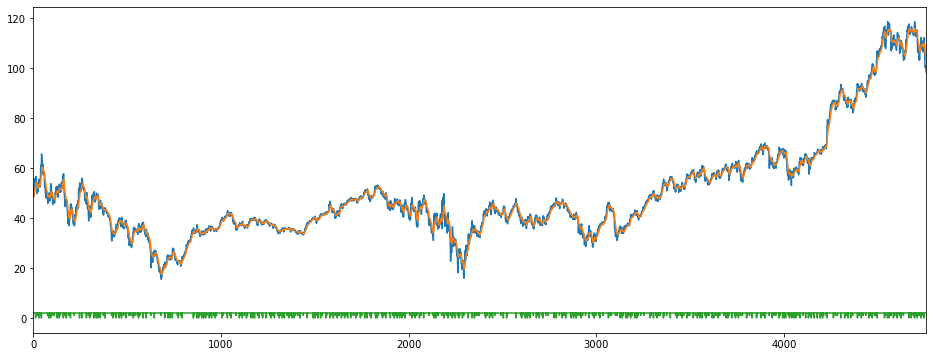

In [50]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

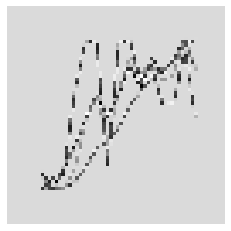

In [56]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [57]:
X = X/255

In [58]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [59]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [60]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [62]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 1s 49ms/step - loss: 0.2458 - accuracy: 0.3501 - mse: 1.6253 - weighted_accuracy: 0.3201 - weighted_mse: 1.7327 - val_loss: 0.1991 - val_accuracy: 0.0927 - val_mse: 1.0087 - val_weighted_accuracy: 0.0927 - val_weighted_mse: 1.0087
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2039 - accuracy: 0.3512 - mse: 1.1816 - weighted_accuracy: 0.3423 - weighted_mse: 1.1780 - val_loss: 0.2072 - val_accuracy: 0.0432 - val_mse: 0.9964 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.9964
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2029 - accuracy: 0.3217 - mse: 1.1828 - weighted_accuracy: 0.3294 - weighted_mse: 1.1860 - val_loss: 0.1995 - val_accuracy: 0.5121 - val_mse: 0.8274 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 0.8274
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2027 

30/30 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.2242 - mse: 1.2026 - weighted_accuracy: 0.4227 - weighted_mse: 1.1759 - val_loss: 0.1992 - val_accuracy: 0.0695 - val_mse: 0.9600 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 0.9600
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1940 - accuracy: 0.2342 - mse: 1.1931 - weighted_accuracy: 0.4353 - weighted_mse: 1.1895 - val_loss: 0.2012 - val_accuracy: 0.0643 - val_mse: 1.0567 - val_weighted_accuracy: 0.0643 - val_weighted_mse: 1.0567
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1944 - accuracy: 0.2194 - mse: 1.1942 - weighted_accuracy: 0.4002 - weighted_mse: 1.1924 - val_loss: 0.1980 - val_accuracy: 0.0674 - val_mse: 0.9353 - val_weighted_accuracy: 0.0674 - val_weighted_mse: 0.9353
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1949 - accuracy: 0.2200 - mse: 1.2249 - weighted_accuracy: 0.4139 - weighted_mse: 1.2

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1760 - accuracy: 0.1581 - mse: 1.2966 - weighted_accuracy: 0.5188 - weighted_mse: 1.2354 - val_loss: 0.1998 - val_accuracy: 0.1117 - val_mse: 1.0748 - val_weighted_accuracy: 0.1117 - val_weighted_mse: 1.0748
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.1552 - mse: 1.3191 - weighted_accuracy: 0.5595 - weighted_mse: 1.3033 - val_loss: 0.1984 - val_accuracy: 0.1159 - val_mse: 1.1163 - val_weighted_accuracy: 0.1159 - val_weighted_mse: 1.1163
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1724 - accuracy: 0.1583 - mse: 1.2909 - weighted_accuracy: 0.5307 - weighted_mse: 1.2461 - val_loss: 0.1994 - val_accuracy: 0.1317 - val_mse: 1.1182 - val_weighted_accuracy: 0.1317 - val_weighted_mse: 1.1182
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1723 - accuracy: 0.1660 - mse: 1.3098 - weighted_accuracy: 0.5400 - weig

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1481 - accuracy: 0.2210 - mse: 1.4961 - weighted_accuracy: 0.6451 - weighted_mse: 1.5362 - val_loss: 0.1983 - val_accuracy: 0.1812 - val_mse: 1.3241 - val_weighted_accuracy: 0.1812 - val_weighted_mse: 1.3241
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1510 - accuracy: 0.2113 - mse: 1.5089 - weighted_accuracy: 0.6117 - weighted_mse: 1.4954 - val_loss: 0.1978 - val_accuracy: 0.1918 - val_mse: 1.3404 - val_weighted_accuracy: 0.1918 - val_weighted_mse: 1.3404
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1511 - accuracy: 0.2237 - mse: 1.5040 - weighted_accuracy: 0.6292 - weighted_mse: 1.4934 - val_loss: 0.1959 - val_accuracy: 0.2013 - val_mse: 1.3390 - val_weighted_accuracy: 0.2013 - val_weighted_mse: 1.3390
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1491 - accuracy: 0.2218 - mse: 1.4893 - weighted_accuracy: 0.6249 - wei

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1348 - accuracy: 0.3454 - mse: 1.7621 - weighted_accuracy: 0.7094 - weighted_mse: 1.9517 - val_loss: 0.1880 - val_accuracy: 0.3151 - val_mse: 1.5354 - val_weighted_accuracy: 0.3151 - val_weighted_mse: 1.5354
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1339 - accuracy: 0.3488 - mse: 1.7282 - weighted_accuracy: 0.7073 - weighted_mse: 1.8995 - val_loss: 0.1890 - val_accuracy: 0.3098 - val_mse: 1.5458 - val_weighted_accuracy: 0.3098 - val_weighted_mse: 1.5458
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1312 - accuracy: 0.3533 - mse: 1.7891 - weighted_accuracy: 0.7050 - weighted_mse: 2.0363 - val_loss: 0.1857 - val_accuracy: 0.3530 - val_mse: 1.5736 - val_weighted_accuracy: 0.3530 - val_weighted_mse: 1.5736
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1316 - accuracy: 0.3548 - mse: 1.8262 - weighted_accuracy: 0.6963 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1206 - accuracy: 0.5018 - mse: 2.1123 - weighted_accuracy: 0.7721 - weighted_mse: 2.5960 - val_loss: 0.1675 - val_accuracy: 0.5385 - val_mse: 1.8216 - val_weighted_accuracy: 0.5385 - val_weighted_mse: 1.8216
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1194 - accuracy: 0.4916 - mse: 2.1445 - weighted_accuracy: 0.7744 - weighted_mse: 2.6236 - val_loss: 0.1666 - val_accuracy: 0.5479 - val_mse: 1.8221 - val_weighted_accuracy: 0.5479 - val_weighted_mse: 1.8221
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1166 - accuracy: 0.5087 - mse: 2.1478 - weighted_accuracy: 0.7844 - weighted_mse: 2.6997 - val_loss: 0.1690 - val_accuracy: 0.5132 - val_mse: 1.8000 - val_weighted_accuracy: 0.5132 - val_weighted_mse: 1.8000
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1181 - accuracy: 0.5182 - mse: 2.1588 - weighted_accuracy: 0.7704 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1040 - accuracy: 0.6062 - mse: 2.7209 - weighted_accuracy: 0.8158 - weighted_mse: 3.7688 - val_loss: 0.1459 - val_accuracy: 0.6754 - val_mse: 2.1370 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 2.1370
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1046 - accuracy: 0.6204 - mse: 2.6820 - weighted_accuracy: 0.8152 - weighted_mse: 3.7553 - val_loss: 0.1552 - val_accuracy: 0.6270 - val_mse: 2.2343 - val_weighted_accuracy: 0.6270 - val_weighted_mse: 2.2343
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1065 - accuracy: 0.6238 - mse: 2.7022 - weighted_accuracy: 0.8149 - weighted_mse: 3.6325 - val_loss: 0.1445 - val_accuracy: 0.6902 - val_mse: 2.2122 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 2.2122
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1015 - accuracy: 0.6109 - mse: 2.8483 - weighted_accuracy: 0.8214 - 

In [63]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1288895308971405
Test accuracy: 0.786090612411499


In [64]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.6552384  -0.37606704 -0.43343103]
 [-1.1025032  -2.065693   -0.11228035]
 [ 0.21516931 -3.9048388  -0.77801836]
 ...
 [-2.2819755  -1.3647679  -0.0693325 ]
 [-1.3707583  -1.4293122  -0.15998559]
 [-0.8717561  -2.197347   -0.22768603]]


Counter({1: 59, 2: 808, 0: 82})

In [65]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 33
actual holds but predicted buy: 55
actual holds but predicted sell: 74
actual predicted holds: 736
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 17.073170731707318%
Percentage holds correct: 85.08670520231213%
actual buys: 43
actual sells: 41
actual holds: 865


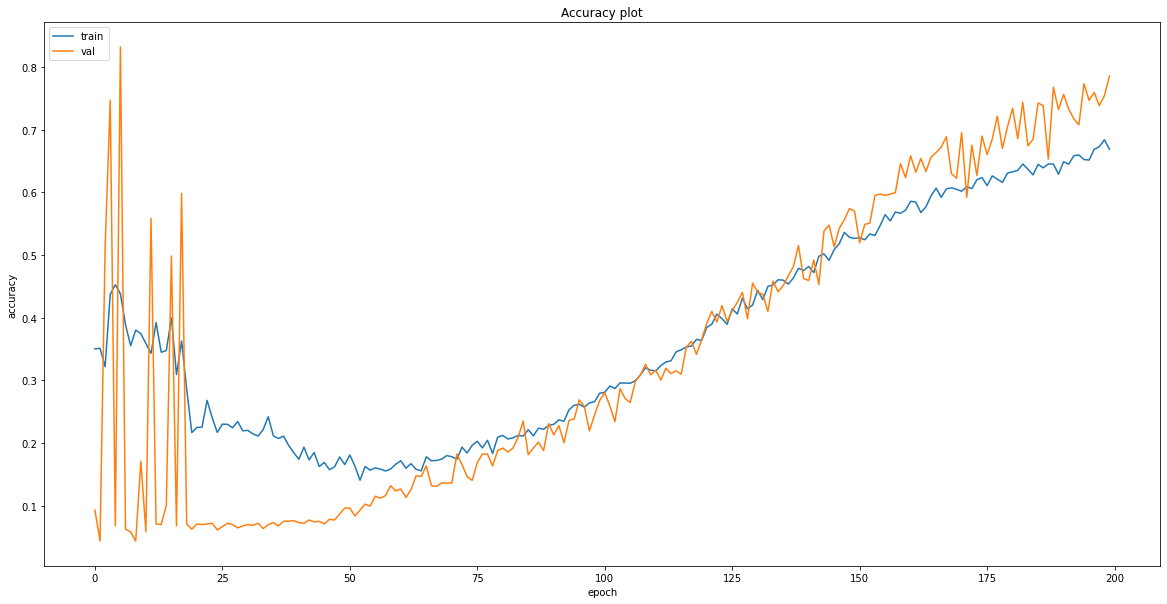

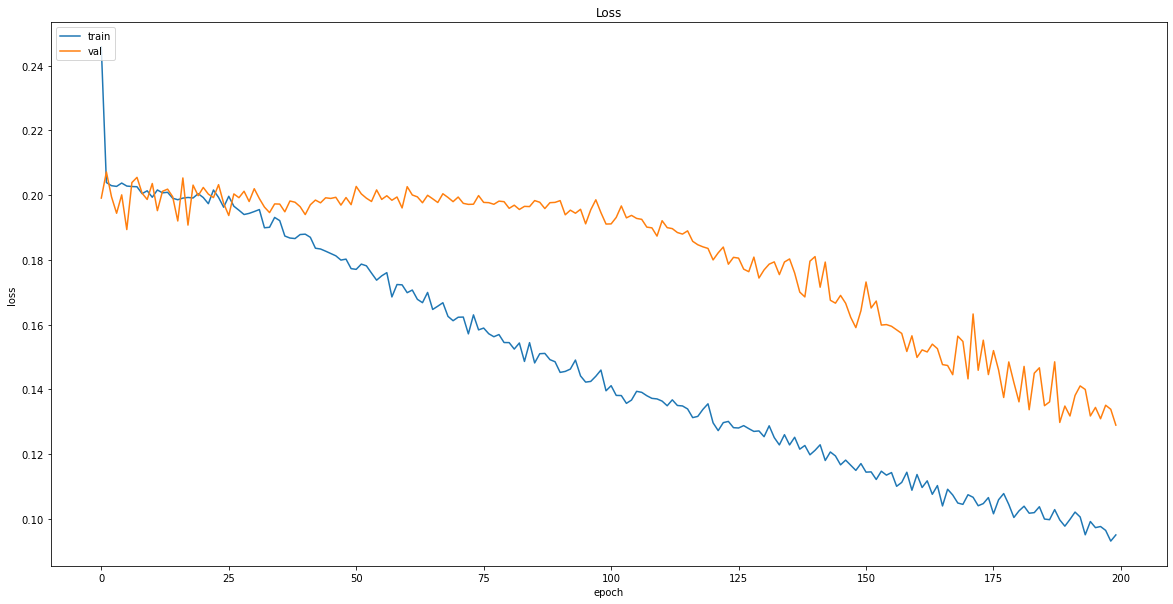

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
# Save model
model.save("models/{}".format('JPM_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JPM_image_cnn_buy_hold_sell.model\assets
